In [2]:
from typing import List, Dict, Any
from typing_extensions import TypedDict

class State(TypedDict):
    url: str
    descricao: str
    tendencias_mercado: str
    avaliacao: int
    resposta_final: str
    enough: bool
    interacoes: int
    pensamentos: List[str]

In [3]:
import requests
from bs4 import BeautifulSoup
import re
from typing import List, Dict, Any
from functools import lru_cache
from langchain_groq import ChatGroq
from constants import State
from dotenv import load_dotenv

load_dotenv()

# Inicializar o modelo de IA
llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0.7)


@lru_cache(maxsize=100)
def fetch_website_content(url: str) -> str:
    """
    Extrai o conteúdo textual de uma URL.
    
    Args:
        url: URL do site a ser analisado
        
    Returns:
        str: Conteúdo textual extraído do site
    """
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser")
            text = soup.get_text(separator=" ", strip=True)
            return text
        return f"Error: Unable to fetch website content (status {response.status_code})"
    except Exception as e:
        return f"Exception: {str(e)}"


def step_descriptor(state: State) -> dict:
    """
    Nó que gera uma descrição concisa do site analisado.
    
    Args:
        state: Estado atual do processamento
        
    Returns:
        dict: Estado atualizado com a descrição
    """
    content = fetch_website_content(state["url"])
    if content.startswith("Error") or content.startswith("Exception"):
        return {"descricao": content}
    
    snippet = content[:1000]
    prompt = (
        f"Forneça um descritor conciso de uma linha resumindo o conteúdo do site.\n\n"
        f"Trecho do conteúdo:\n{snippet}"
    )
    response_msg = llm.invoke(prompt)
    descriptor = response_msg.content
    return {**state, "descricao": descriptor.strip()}


def step_decision(state: State) -> dict:
    """
    Nó que decide se há informações suficientes para uma avaliação confiável.
    
    Args:
        state: Estado atual do processamento
        
    Returns:
        dict: Estado atualizado com a decisão
    """
    if state["interacoes"] >= 3:
        return {"enough": True}
    
    prompt = (
        f"Com base na seguinte descrição do site:\n'{state['descricao']}'\n"
        f"e os insights adicionais até agora: {', '.join(state['pensamentos']) if state['pensamentos'] else 'Nenhum'}\n"
        "Você tem informações suficientes para avaliar esta ideia de negócio de forma confiável? "
        "Responda com True ou False."
    )
    decision_msg = llm.invoke(prompt)
    decision_text = decision_msg.content
    enough = "True" in decision_text.lower()
    return {**state, "enough": enough}


def step_think_more(state: State) -> dict:
    """
    Nó que gera insights adicionais quando necessário.
    
    Args:
        state: Estado atual do processamento
        
    Returns:
        dict: Estado atualizado com novos insights
    """
    new_iter = state["interacoes"] + 1
    
    # Gerar novo insight
    prompt_insight = (
        f"Descrição do site: '{state['descricao']}'.\n"
        f"Insights existentes: {', '.join(state['pensamentos']) if state['pensamentos'] else 'Nenhum'}.\n"
        "Qual é um insight ou fator adicional que deve ser considerado para avaliar esta ideia de negócio? "
        "Responda em uma frase concisa."
    )
    insight_msg = llm.invoke(prompt_insight)
    new_thought = insight_msg.content.strip()
    updated_thoughts = state["pensamentos"] + [new_thought]
    
    # Gerar tendências de mercado atualizadas
    prompt_trends = (
        f"Com base na descrição do site '{state['descricao']}' e no novo insight '{new_thought}', "
        "forneça um resumo atualizado e breve das tendências de mercado relevantes em uma frase."
    )
    trends_msg = llm.invoke(prompt_trends)
    new_trends = trends_msg.content.strip()
    
    return {
        **state,
        "interacoes": new_iter,
        "pensamentos": updated_thoughts,
        "tendencias_mercado": new_trends
    }


def step_finalize(state: State) -> dict:
    """
    Nó final que gera a avaliação completa do negócio.
    
    Args:
        state: Estado atual do processamento
        
    Returns:
        dict: Estado atualizado com a avaliação final
    """
    prompt = (
        f"Usando a descrição do site:\n'{state['descricao']}'\n"
        f"e os seguintes insights adicionais: {', '.join(state['pensamentos']) if state['pensamentos'] else 'Nenhum'}\n"
        f"com resumo das tendências de mercado: '{state['tendencias_mercado']}'\n"
        "Forneça uma avaliação final do negócio em 3-5 linhas e classifique a ideia de negócio em uma escala de 1 (ruim) a 10 (excelente). "
        "IMPORTANTE: Formate sua resposta EXATAMENTE assim: 'Resumo Final: [sua análise aqui]; Avaliação: [número de 1 a 10]'"
    )

    final_msg = llm.invoke(prompt)
    final = final_msg.content.strip()
    
    # Procurar por diferentes formatos de avaliação
    patterns = [
        r'Avaliação:\s*(\d+)',
        r'Rating:\s*(\d+)',
        r'Nota:\s*(\d+)',
        r'Score:\s*(\d+)',
        r'(\d+)/10',
        r'(\d+)\s*de\s*10',
        r'(\d+)\s*out\s*of\s*10'
    ]
    
    rating = 0
    for pattern in patterns:
        match = re.search(pattern, final, re.IGNORECASE)
        if match:
            rating = int(match.group(1))
            break
    
    # Se não encontrou nenhum padrão, procurar por qualquer número entre 1-10
    if rating == 0:
        numbers = re.findall(r'\b([1-9]|10)\b', final)
        if numbers:
            rating = int(numbers[-1])  # Pega o último número encontrado
    
    return {**state,
        "resposta_final": final,
        "avaliacao": rating}


In [4]:

def decision_router(state: State) -> str:
    """
    Função de roteamento após o nó de decisão.
    
    Determina se deve continuar gerando insights ou finalizar a avaliação
    baseado no estado atual do processamento.
    
    Args:
        state: Estado atual do processamento
        
    Returns:
        str: Nome do próximo nó a ser executado
            - "step_think_more": Se precisa de mais insights
            - "step_finalize": Se tem informações suficientes
    """
    if state.get("enough", False):
        return "step_finalize"
    return "step_think_more"


def error_router(state: State) -> str:
    """
    Função de roteamento para tratamento de erros.
    
    Determina o próximo passo quando ocorre um erro no processamento.
    
    Args:
        state: Estado atual do processamento
        
    Returns:
        str: Nome do próximo nó a ser executado
    """
    # Se há erro na descrição, finalizar com erro
    if state.get("descricao", "").startswith(("Error", "Exception")):
        return "step_finalize"
    
    # Caso contrário, continuar com decisão
    return "step_decision"


def validate_state(state: State) -> bool:
    """
    Valida se o estado atual é válido para continuar o processamento.
    
    Args:
        state: Estado atual do processamento
        
    Returns:
        bool: True se o estado é válido, False caso contrário
    """
    required_fields = ["url", "descricao"]
    
    for field in required_fields:
        if field not in state or not state[field]:
            return False
    
    return True


def get_next_node(current_node: str, state: State) -> str:
    """
    Função genérica para determinar o próximo nó baseado no nó atual e estado.
    
    Args:
        current_node: Nome do nó atual
        state: Estado atual do processamento
        
    Returns:
        str: Nome do próximo nó a ser executado
    """
    # Mapeamento de nós para próximos nós
    node_mapping = {
        "step_descriptor": "step_decision",
        "step_decision": decision_router(state),
        "step_think_more": "step_decision",
        "step_finalize": "END"
    }
    
    return node_mapping.get(current_node, "step_finalize")

In [5]:

from pprint import pprint
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END


load_dotenv()


def build_graph():
    """
    Constrói o grafo de processamento para avaliação de negócios.
    
    O grafo implementa o seguinte fluxo:
    1. step_descriptor: Extrai e descreve o conteúdo do site
    2. step_decision: Decide se há informações suficientes
    3. step_think_more: Gera insights adicionais (se necessário)
    4. step_finalize: Produz a avaliação final
    
    Returns:
        CompiledGraph: Grafo compilado pronto para execução
    """
    graph_builder = StateGraph(State)
    
    # Adiciona os nós do grafo
    graph_builder.add_node("step_descriptor", step_descriptor)
    graph_builder.add_node("step_decision", step_decision)
    graph_builder.add_node("step_think_more", step_think_more)
    graph_builder.add_node("step_finalize", step_finalize)
    
    # Configura as transições entre nós
    graph_builder.add_edge(START, "step_descriptor")
    graph_builder.add_edge("step_descriptor", "step_decision")
    
    # Roteamento condicional baseado na decisão
    graph_builder.add_conditional_edges(
        "step_decision", 
        decision_router, 
        {
            "step_think_more": "step_think_more", 
            "step_finalize": "step_finalize"
        }
    )
    
    # Loop de volta para decisão após gerar mais insights
    graph_builder.add_edge("step_think_more", "step_decision")
    
    # Finalização do processamento
    graph_builder.add_edge("step_finalize", END)
    
    # Compila e retorna o grafo
    return graph_builder.compile()

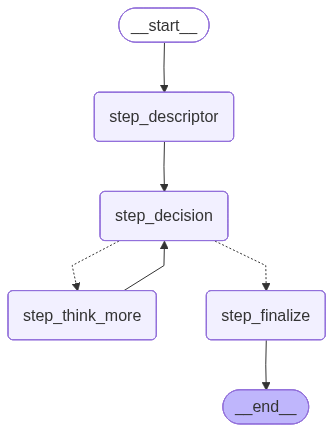

In [6]:
app = build_graph()
app